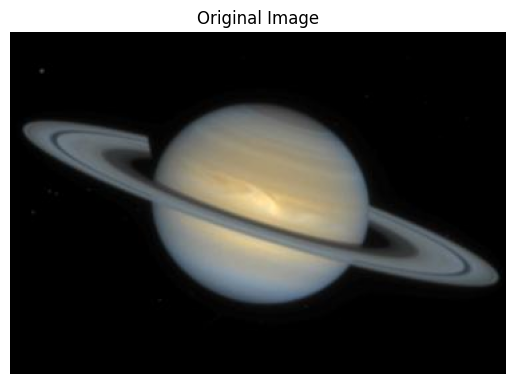

nR:  1.513063997196311
nG:  1.5185223876207927
nB:  1.5267693539161435
Chromatic aberration (focal length difference):  7.8144954243842335
Max output image size:  (1515, 2195)
SSIM between Red and Blue channels: 0.725629638718034


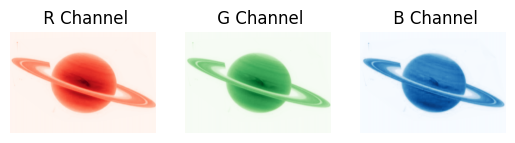

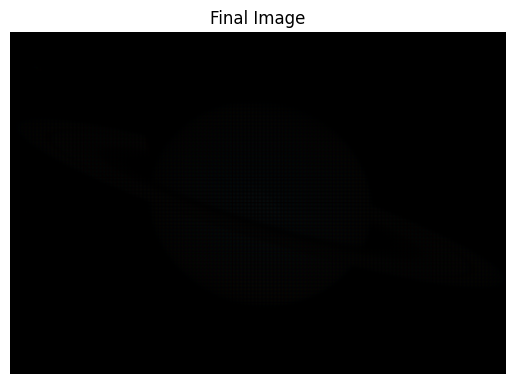

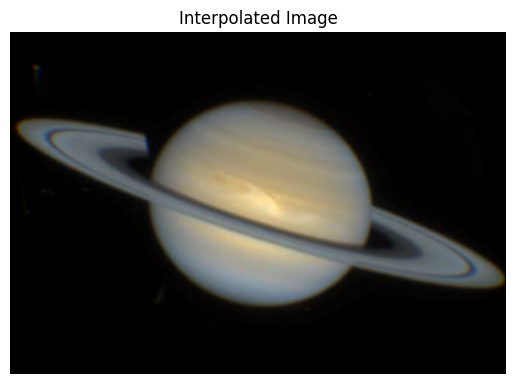

Interpolated image saved to ../results/interpolated_image.jpg


In [ ]:
import sys
sys.path.append('..')

import numpy as np
import cv2 # type: ignore
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.utilities import *
from scipy.interpolate import griddata
from skimage.metrics import structural_similarity as ssim
from src.refractive_idxs import *

# Load the image
image_path = "../assets/PIA01464.jpg" 
#image_path = "../assets/PIA02270.jpg"  
#image_path = "../assets/moon_SC_2016_07_15-1.jpg"
#image_path = "../assets/jupiter-through-a-16-telescope-v0-8w9mx1hyqxwa1.webp"

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

R, G, B = cv2.split(img_rgb)

n1 = 1.0  # Air

R1_o = 308.2   # Radius of curvature of the first surface (in mm)
R2_o = -308.2  # Radius of curvature of the second surface (in mm)
d_o = 5.1  # Thickness of the lens (in mm)

R1_e = -52.1
R2_e = 52.1
d_e = 3.5

nR = refractive_index_NBK7(0.700)
nG = refractive_index_NBK7(0.550)
nB = refractive_index_NBK7(0.435)
n_reference = refractive_index_NBK7(0.5876)
print("nR: ", nR)
print("nG: ", nG)
print("nB: ", nB)

aperture_radius = 50.8 # Aperture radius (in mm)

refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, refer_output_img_size, refer_M_T, refer_M = get_parameters(R, n1, n_reference, R1_o, R2_o, d_o, R1_e, R2_e, d_e)

fov_iR, f_oR, f_eR, i_angular_pixel_sizeR, i_lateral_pixel_sizeR, output_img_sizeR, M_TR, MR = get_parameters(R, n1, nR, R1_o, R2_o, d_o, R1_e, R2_e, d_e)
fov_iG, f_oG, f_eG, i_angular_pixel_sizeG, i_lateral_pixel_sizeG, output_img_sizeG, M_TG, MG = get_parameters(G, n1, nG, R1_o, R2_o, d_o, R1_e, R2_e, d_e)
fov_iB, f_oB, f_eB, i_angular_pixel_sizeB, i_lateral_pixel_sizeB, output_img_sizeB, M_TB, MB = get_parameters(B, n1, nB, R1_o, R2_o, d_o, R1_e, R2_e, d_e)

max_f_o = max(f_oR, f_oG, f_oB)
min_f_o = min(f_oR, f_oG, f_oB)
print("Chromatic aberration (focal length difference): ", max_f_o - min_f_o)

max_output_img_size = max(output_img_sizeR, output_img_sizeG, output_img_sizeB)
print("Max output image size: ", max_output_img_size)

# Aquí sale con más aberración
final_imageR = telescope(R, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TR, refer_M)
final_imageG = telescope(G, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TG, refer_M)
final_imageB = telescope(B, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TB, refer_M)
         
final_image = cv2.merge((final_imageB, final_imageG, final_imageR))

ssim_value = ssim(final_imageR, final_imageB)
print(f"SSIM between Red and Blue channels: {ssim_value}")

# Interpolate each channel separately
interpolated_R = griddata(
    np.argwhere(final_imageR > 0), final_imageR[final_imageR > 0],
    (np.indices(final_imageR.shape)[0], np.indices(final_imageR.shape)[1]),
    method='linear', fill_value=0
)

interpolated_G = griddata(
    np.argwhere(final_imageG > 0), final_imageG[final_imageG > 0],
    (np.indices(final_imageG.shape)[0], np.indices(final_imageG.shape)[1]),
    method='linear', fill_value=0
)

interpolated_B = griddata(
    np.argwhere(final_imageB > 0), final_imageB[final_imageB > 0],
    (np.indices(final_imageB.shape)[0], np.indices(final_imageB.shape)[1]),
    method='linear', fill_value=0
)

plt.subplot(1, 3, 1)
plt.imshow(interpolated_R, cmap='Reds')
plt.title(' R Channel')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(interpolated_G, cmap='Greens')
plt.title(' G Channel')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(interpolated_B, cmap='Blues')
plt.title(' B Channel')
plt.axis('off')
plt.show()

# Merge the interpolated channels back into a single image
interpolated_image = cv2.merge((interpolated_R, interpolated_G, interpolated_B))

plt.imshow(final_image)
plt.title('Final Image')
plt.axis('off')
plt.show()

interpolated_image = np.clip(interpolated_image, 0, 255)
interpolated_image = interpolated_image.astype(np.uint8)

plt.imshow(interpolated_image)
plt.title('Interpolated Image')
plt.axis('off')
plt.show()

# Save the interpolated image
output_path = "../results/interpolated_image.jpg"
cv2.imwrite(output_path, cv2.cvtColor(interpolated_image, cv2.COLOR_RGB2BGR))
print(f"Interpolated image saved to {output_path}")